<a href="https://colab.research.google.com/github/prateekkosta/Time-Series-analysis-for-Air-Passengers/blob/main/Time_Series_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Objective**: Build a model to forecast the demand(passenger traffic) in Airplanes. The data is classified in date/time and the passengers travelling per month

In [ ]:
from IPython.core.interactiveshell import warnings
from logging import warning
from datetime import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
from matplotlib.pylab import rcParams
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
import statsmodels.tsa.api as smt
rcParams['figure.figsize']= 10,6
import warnings
warnings.filterwarnings('ignore')

!pip install pmdarima
import pmdarima as pm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 29.9 MB/s eta 0:00:00


**Read Data**
Time series deals with 2 columns, one is temporal ie: month in this case & another is the value to be forecasted ie: airplane passengers. To make plotting graphs easier, we set the index of pandas dataframe to the Month. During plots, the index will act by default as the x-axis & since it has only 1 more column, that will be automatically taken as the y-axis

In [ ]:
import io
from google.colab import files
uploaded= files.upload()

Saving AirPassengers.csv to AirPassengers.csv


In [ ]:
dataset= pd.read_csv(io.BytesIO(uploaded['AirPassengers.csv']))

dataset.head(10)

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
5,1949-06,135
6,1949-07,148
7,1949-08,148
8,1949-09,136
9,1949-10,119


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [ ]:
dataset.describe()

,#Passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


COnverting Object Datatype to Date Time format

In [ ]:
dataset['Month']= pd.to_datetime(dataset['Month'], infer_datetime_format= True)

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Month        144 non-null    datetime64[ns]
 1   #Passengers  144 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.4 KB


Making Month Column as Index column

In [ ]:
indexedDataset= dataset.set_index(['Month'])

indexedDataset.head(5)

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


Now Checking For Trend Component in Data

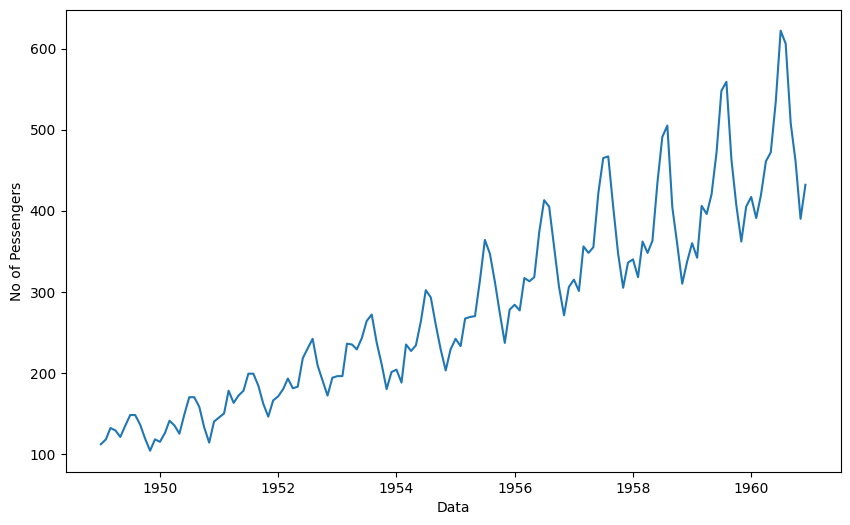

In [ ]:
# Plotting Graph

plt.xlabel('Data')
plt.ylabel('No of Pessengers')
plt.plot(indexedDataset)


Analysis Of Graph-  

1.  Graph has a upward trend.
2.  It has Seasonality.
3.  It looks like Multiplicative Time series


      

## **Decomposing Time Series**

<function matplotlib.pyplot.show(close=None, block=None)>

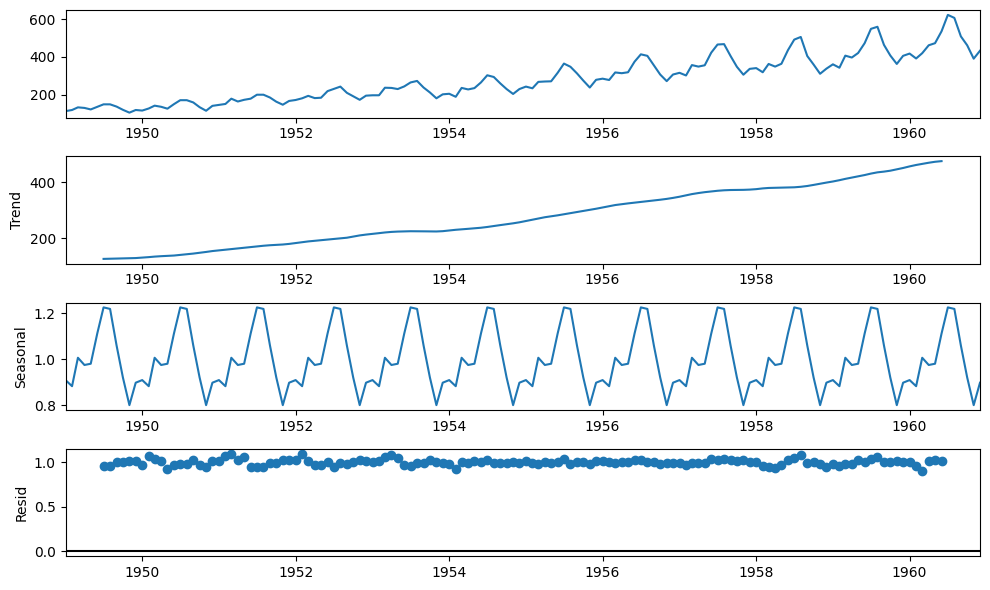

In [ ]:
# Data clealy has a linear Uptrend
# a clear cut seasonal pattern of a 1 year duration is present in the data

dec= seasonal_decompose(indexedDataset, model= 'multiplicative', period = 12).plot()
plt.show

Extracting the values for Trend, Seasonal and Residual from Decompossed Data

In [ ]:
decomposed= seasonal_decompose(indexedDataset, period= 12, model = 'multiplicative')
original_vs_decompossed_series = pd.concat([decomposed.observed, decomposed.trend, decomposed.seasonal, decomposed.resid], axis= 1)
original_vs_decompossed_series.columns= ['Actual','Trend','Seasonal','Residual or Unexplained']
original_vs_decompossed_series.to_csv('original_vs_decompossed_series.csv')
#files.download('original_vs_decompossed_series.csv')

In [ ]:
original_vs_decompossed_series= original_vs_decompossed_series.reset_index()
original_vs_decompossed_series.head(5)

,Month,Actual,Trend,Seasonal,Residual or Unexplained
0,1949-01-01,112.0,NaN,0.910230,NaN
1,1949-02-01,118.0,NaN,0.883625,NaN
2,1949-03-01,132.0,NaN,1.007366,NaN
3,1949-04-01,129.0,NaN,0.975906,NaN
4,1949-05-01,121.0,NaN,0.981378,NaN


In [ ]:
#Adding rank column in Decompossed series
#creating the rank column and passing the returned rank series

original_vs_decompossed_series['Rank']= original_vs_decompossed_series['Month'].rank()

In [ ]:
original_vs_decompossed_series.head(5)

,Month,Actual,Trend,Seasonal,Residual or Unexplained,Rank
0,1949-01-01,112.0,NaN,0.910230,NaN,1.0
1,1949-02-01,118.0,NaN,0.883625,NaN,2.0
2,1949-03-01,132.0,NaN,1.007366,NaN,3.0
3,1949-04-01,129.0,NaN,0.975906,NaN,4.0
4,1949-05-01,121.0,NaN,0.981378,NaN,5.0


In [ ]:
#spliting the data into x and y

data_for_model = original_vs_decompossed_series.dropna()
x= data_for_model.loc[:,['Rank']]
y= data_for_model['Trend']

#fitting a linear model
x= sm.add_constant(x)
model = sm.OLS(y,x).fit()

In [ ]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Trend   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                 1.134e+04
Date:                Thu, 29 Jun 2023   Prob (F-statistic):          2.38e-128
Time:                        17:55:45   Log-Likelihood:                -502.37
No. Observations:                 132   AIC:                             1009.
Df Residuals:                     130   BIC:                             1015.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         84.6483      2.051     41.272      0.0

In [ ]:
#predicting Trend values

original_vs_decompossed_series['Predicted_trend']= (original_vs_decompossed_series['Rank']*2.6669 +84.6483)
original_vs_decompossed_series.head(5)

,Month,Actual,Trend,Seasonal,Residual or Unexplained,Rank,Predicted_trend
0,1949-01-01,112.0,NaN,0.910230,NaN,1.0,87.3152
1,1949-02-01,118.0,NaN,0.883625,NaN,2.0,89.9821
2,1949-03-01,132.0,NaN,1.007366,NaN,3.0,92.6490
3,1949-04-01,129.0,NaN,0.975906,NaN,4.0,95.3159
4,1949-05-01,121.0,NaN,0.981378,NaN,5.0,97.9828


In [ ]:
original_vs_decompossed_series['predicted_timeseries']= original_vs_decompossed_series['Predicted_trend']*original_vs_decompossed_series['Seasonal']

Plotting Basic Model


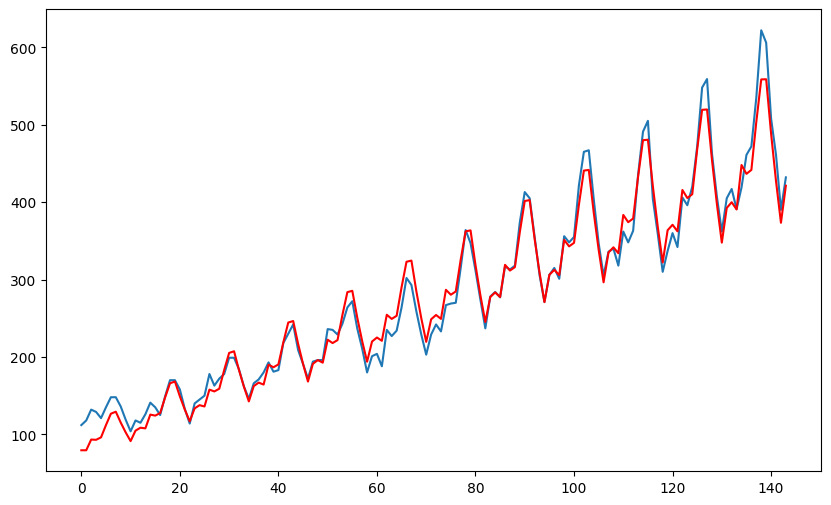

In [ ]:
plt.plot(original_vs_decompossed_series['Actual'])
plt.plot(original_vs_decompossed_series['predicted_timeseries'], color= 'red')
print('Plotting Basic Model')

In [ ]:
error= np.sqrt(mean_squared_error(original_vs_decompossed_series['Actual'], original_vs_decompossed_series['predicted_timeseries']))
print('Total RMSE : %.4f' %error)

Total RMSE : 17.3236


## **fbprophet Package for Time series Modeling**

In [ ]:
!pip install prophet

In [ ]:
import prophet
from prophet import Prophet

In [ ]:
dataset_fb = dataset
dataset_fb.columns = ['ds', 'y']
model = Prophet(seasonality_mode= 'multiplicative')
model.fit(dataset_fb)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpj037_2qv/6uxz310o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpj037_2qv/b9tuz30l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=758', 'data', 'file=/tmp/tmpj037_2qv/6uxz310o.json', 'init=/tmp/tmpj037_2qv/b9tuz30l.json', 'output', 'file=/tmp/tmpj037_2qv/prophet_modelkhghiydb/prophet_model-20230629175551.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:55:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:55:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
future = model.make_future_dataframe(periods = 36,freq= 'M')

In [ ]:
pred= model.predict(future)
pred[['ds','yhat']].head()

,ds,yhat
0,1949-01-01,104.158588
1,1949-02-01,100.636315
2,1949-03-01,115.099045
3,1949-04-01,116.677798
4,1949-05-01,119.542212


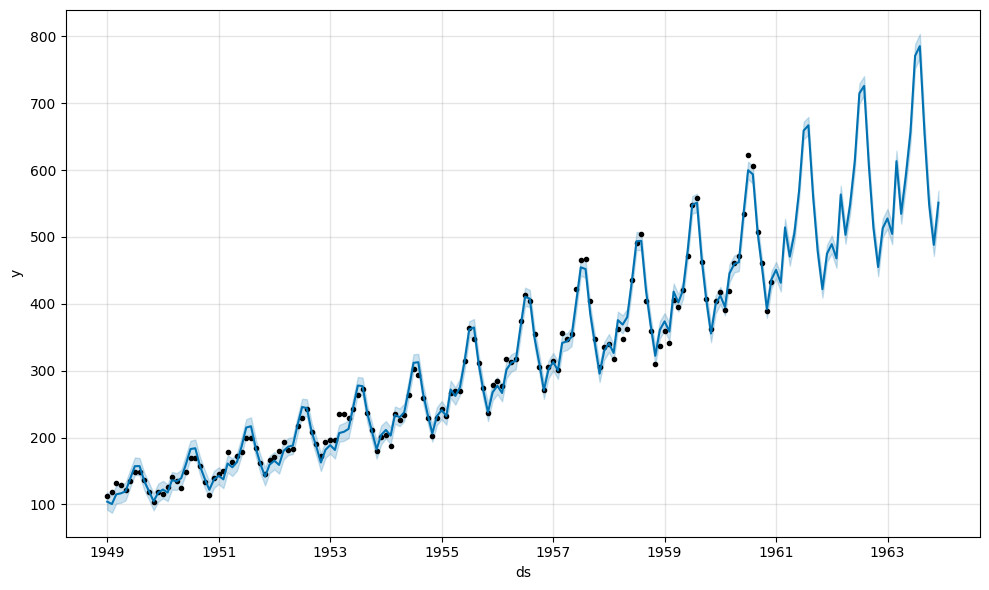

In [ ]:
#Multipicative

plot_model = model.plot(pred)

In [ ]:
error= np.sqrt(mean_squared_error(dataset_fb['y'],pred.loc[0:143,'yhat']))
print("total RMSE: %.4f" %error)

total RMSE: 10.2000


**The Error trend while Using FB Prophet is 10 where as while using traditional method it was 17.**

# Using ARIMA model to predict time series (Old modelling technique)
ARIMA=  Auto Regressive, Integrative, Moving Average

In [ ]:
#how to check if the series is stationary or not(because it is important for ARIMA model)
#There are Two ways to do it-
# a. looking at the trend and and check if it meets all the criteria of stationary series or not(Not very popular method because it is pron to errors)
# b. Augmented Dicky-Fullar test(Very popular method)

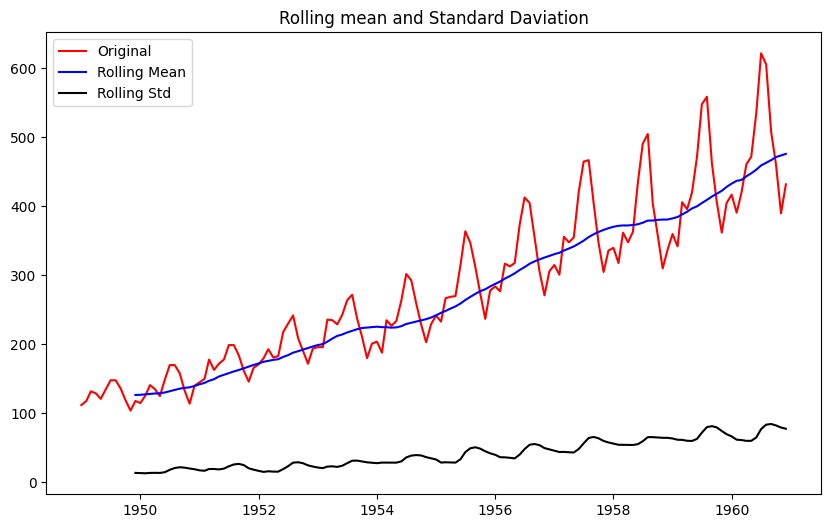

In [ ]:
#Checking time series stationary or not
#plot rolling statistics
rolmean= indexedDataset.rolling(window= 12).mean() #window size denotes 12 months
rolstd= indexedDataset.rolling(window= 12).std()
orig= plt.plot(indexedDataset, color= 'red', label= 'Original' )
mean= plt.plot(rolmean, color= 'blue', label= 'Rolling Mean')
std= plt.plot(rolstd, color= 'black', label= 'Rolling Std')
plt.legend(loc= 'best')
plt.title('Rolling mean and Standard Daviation')
plt.show(block= False)

From the above graph, we see that rolling mean itself has a trend component even though rolling standard deviation is fairly constant with time.

For our time series to be stationary, we need to ensure that both the rolling statistics ie: mean & std. dev. remain time invariant or constant with time. Thus the curves for both of them have to be parallel to the x-axis, which in our case is not so.

To further augment our hypothesis that the time series is not stationary, let us perform the ADF test.

In [ ]:
#Performing Augmented Dicky Fullar test
print('Results of Dicky Fullar test: ')
dftest= adfuller(indexedDataset['#Passengers'])
print("'p' value of ADF test is: ",dftest[1].round(2))
#for timeseries to be stationary the value of ADF should be less than 0.05

Results of Dicky Fullar test: 
'p' value of ADF test is:  0.99


In order to eliminate Trend, seasonality and make the timeseries stationary, we will use Diffrencing

1.   i.e. substracting the previous values from its next value




In [ ]:
indexedDataset_diff = indexedDataset.diff()
indexedDataset_diff= indexedDataset_diff.dropna()

# dec_diff = seasonal_decompose(indexedDataset_diff, period=12).plot()
# plt.show()

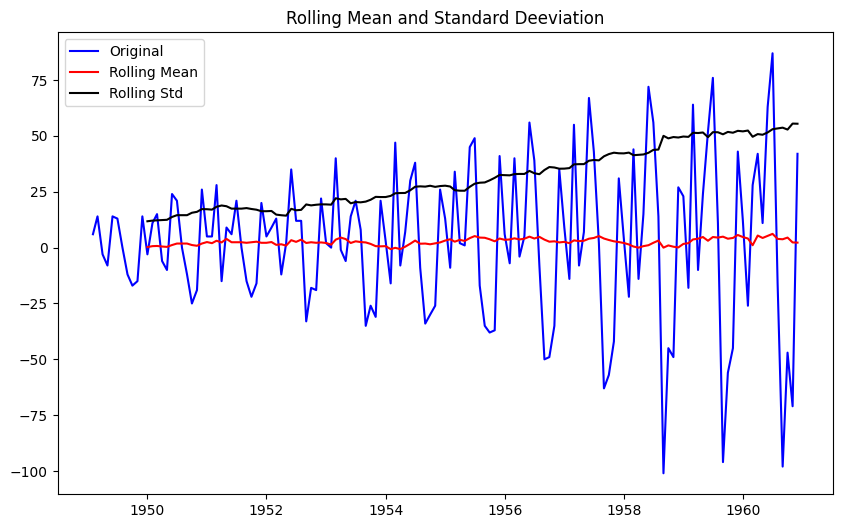

In [ ]:
#plotting Rolling statistics
rolemean_diff= indexedDataset_diff.rolling(window=12).mean()  #window size 12 denotes 12 month
rolestd_diff= indexedDataset_diff.rolling(window=12).std()
orig= plt.plot(indexedDataset_diff, color= 'blue', label= "Original")
mean= plt.plot(rolemean_diff, color='red', label= 'Rolling Mean')
std= plt.plot(rolestd_diff, color= 'black', label= 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean and Standard Deeviation')
plt.show(block= False)

As compared to the Original series the trend component is flat. Though standard deviation is increasing ocer the time




In [ ]:
#Lets Check ADF test value to be sure that we have made series stationary

#performing Augmented Dicky Fullar test
print('Result of Dicky Fullar test :')
dftest_diff= adfuller(indexedDataset_diff['#Passengers'])
print('P Value of ADCF Test is :', dftest_diff[1].round(2))

Result of Dicky Fullar test :
P Value of ADCF Test is : 0.05


For All practical purpose we can assume that our series is Stationary because the value of P is less or equal to 0.05.

In [ ]:
#Now lets try to understand what "ARIMA" model is and what are the components of the model
#ARIMA as the made up of three seperate models:
# a. Auto-regressive (AR): Represented by "p" = 2
# b. Integreated (I): Represented by "d" = 1
# c. Moving Average (MA): Represented by "q" = 1

In [ ]:
#Once "Stationary" condition is met. Next step is finding the values of "p", "d" and "q"
# "d" is easy to calculate as d equal to number of times we have differenced the series to reach stationary (In our case it was once)

#Now lets focus on how to get value of "p" and "q"

In [ ]:
#‘p’ is the order of the ‘Auto Regressive’ (AR) term. It refers to the number of lags of Y to be used as predictors.
#‘q’ is the order of the ‘Moving Average’ (MA) term. It refers to the number of lagged forecast errors that should go into the ARIMA Model.

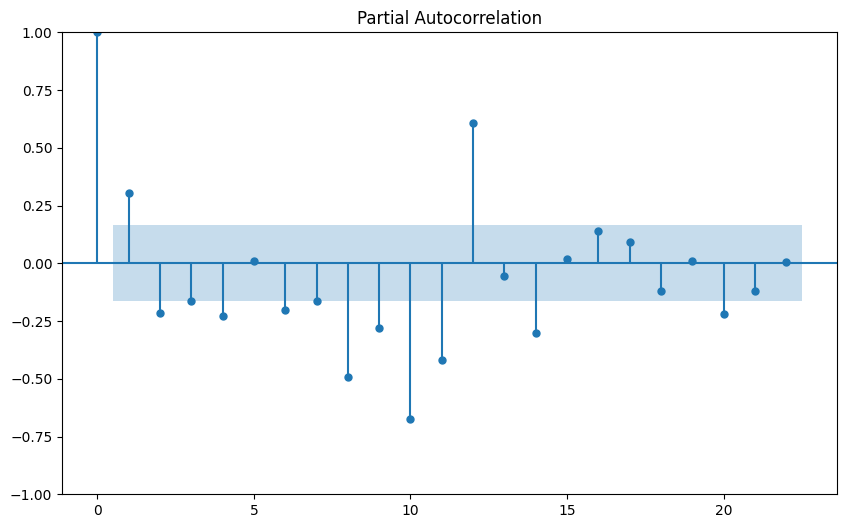

In [ ]:
pacf= plot_pacf(indexedDataset_diff) #for finding order of AR


Here we can see that the first lag is significantly out of the limit and the second one is also out of the significant limit but it is not that far so we can select the order of the p as 2.


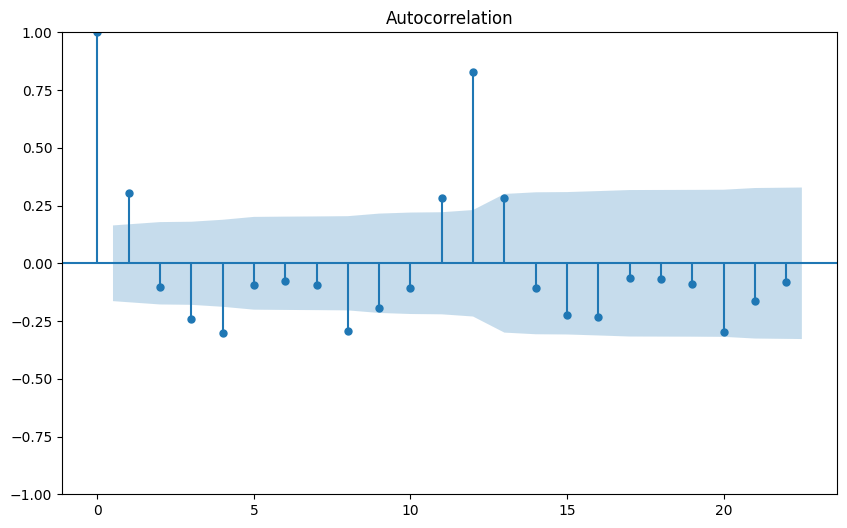

In [ ]:
acf= plot_acf(indexedDataset_diff)  #for finding order of MA

Here we can see that 1 of the lags are out of the significance limit so we can say that the optimal value of our q (MA) is 1

In [ ]:
data= pd.read_csv(io.BytesIO(uploaded['AirPassengers.csv']))
data['Month']= pd.to_datetime(data['Month'], infer_datetime_format= True)
data= data.set_index(['Month'])

In [ ]:
#Standard ARIMA Model
ARIMA_model= pm.auto_arima(data['#Passengers'],
                           start_p= 1,
                           d=1,
                           start_q=1,
                           test= 'adf', #Using ADF test for finding optimal value of 'd'
                           max_p= 2, max_q=2, # max values of p and q
                           seasonal= False #No seasonal componant for Standard ARIMA
                           )
ARIMA_model.order

(2, 1, 1)

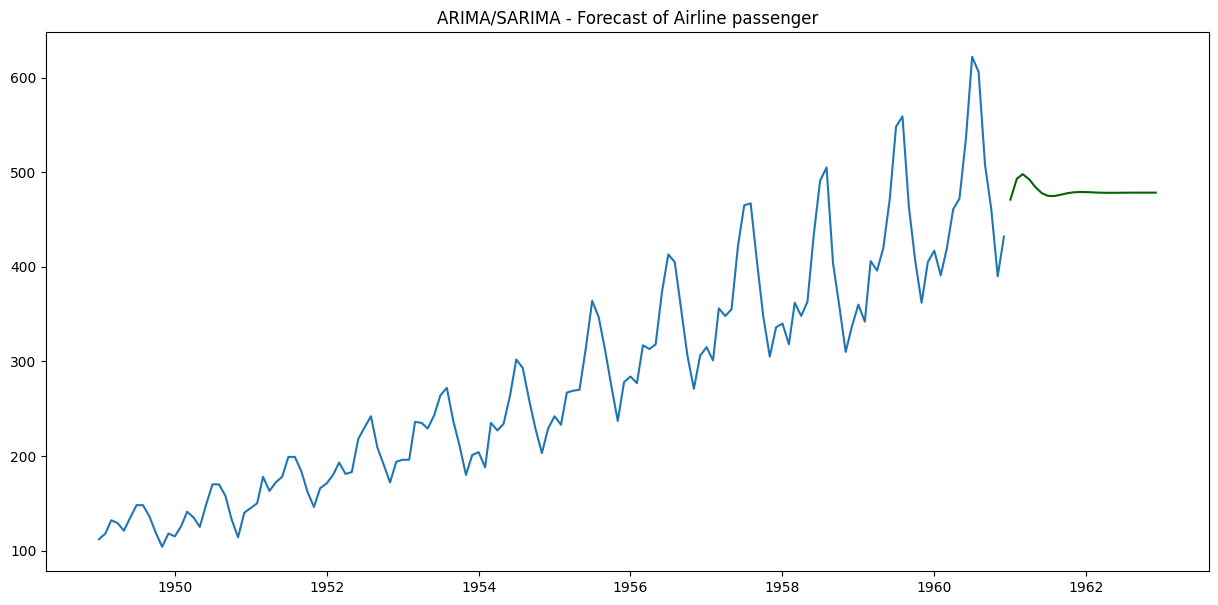

In [ ]:
def forecast(ARIMA_model, period= 24):
  #Forecast
  n_periods= period
  fitted,conflict = ARIMA_model.predict(n_periods=n_periods, return_conf_int = True)
  index_of_fc= pd.date_range(data.index[-1]+ pd.DateOffset(months= 1), periods= n_periods, freq= 'MS')


  #make series for plotting purpose
  fitted_series= pd.Series(fitted, index= index_of_fc)
  #Plotting
  plt.figure(figsize= (15,7))
  plt.plot(data['#Passengers'], color='#1f76b4')
  plt.plot(fitted_series, color= 'darkgreen')
  plt.title('ARIMA/SARIMA - Forecast of Airline passenger')
  plt.show

forecast(ARIMA_model)

Here We Can See that the predictions are different from the rest of the previous graph.

In [ ]:
#Standard SARIMA Model
SARIMA_model= pm.auto_arima(data['#Passengers'],
                            start_p= 1,
                            d= 1,
                            start_q= 1,
                            test= 'adf',
                            max_p= 2, max_q= 2,
                            m=12,   #frequency of Series( If m=1, seasonality is set to False automaticaly)
                            D= 1, #order of the seasonal differencing
                            seasonal = True
                            )
SARIMA_model.order

(0, 1, 1)

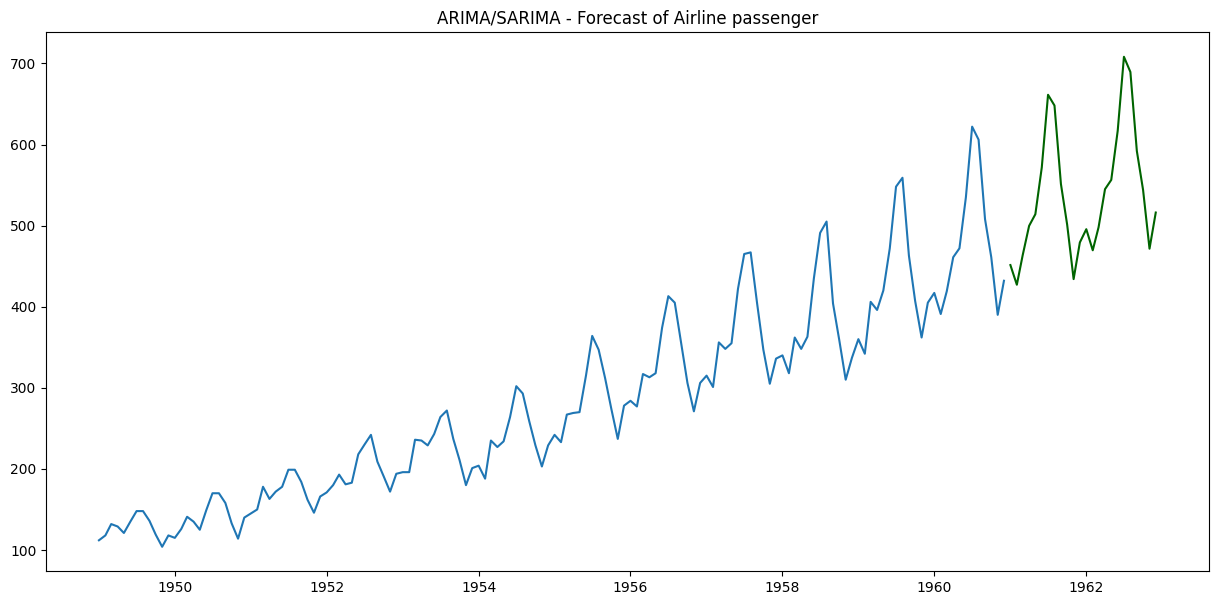

In [ ]:
forecast(SARIMA_model)